In [1]:
#Import all the required library
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from PIL import Image

In [25]:
#Defining the hyperparameters
epochs = 30
lr_rate = 1e-3
batch_size = 128

In [3]:
#This function will be used for image transformation that is required for the PyTorch model
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
#Downloading the MNIST handwritten digit dataset
train_set = datasets.MNIST(root='', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [6]:
#information on the training data and number of classes
print(train_set)
print(train_set.classes)

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [7]:
#Defining the autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #Encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256) # Input image (28*28 = 784)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)

        #Decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784) # Output image (28*28 = 784)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))

        return x

In [8]:
#create object of autoencoder class
model = Autoencoder()
print(model)

Autoencoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


In [9]:
#the loss criteria and the optimization methods will be defined
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr_rate)

In [10]:
#to enable CUDA environment in case available
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [11]:
#create a directory to save the results
def make_dir():
    image_dir = 'MNIST_Out_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [12]:
#save the reconstructed images generated by the model
def save_decod_img(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './MNIST_Out_Images/Autoencoder_image{}.png'.format(epoch))

In [17]:
#train the model
def training(model, train_loader, epochs):
    train_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, epochs, loss))

        if epoch % 5 == 0:
            save_decod_img(outputs.cpu().data, epoch)

    return train_loss

In [18]:
#test the trained model on image reconstruction
def test_image_reconstruct(model, test_loader):
     for batch in test_loader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        outputs = model(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'MNIST_reconstructed_img.png')
        break

In [19]:
#Before training, the model will be pushed to the 
#CUDA environment and the directory will be created to save the result images using the functions defined above.
device = get_device()
model.to(device)
make_dir()

In [26]:
#training of the model will be performed
train_loss = training(model, train_loader, epochs)

epoch 1 of 30, Train Loss: 0.895
epoch 2 of 30, Train Loss: 0.895
epoch 3 of 30, Train Loss: 0.894
epoch 4 of 30, Train Loss: 0.894
epoch 5 of 30, Train Loss: 0.894
epoch 6 of 30, Train Loss: 0.893
epoch 7 of 30, Train Loss: 0.893
epoch 8 of 30, Train Loss: 0.892
epoch 9 of 30, Train Loss: 0.892
epoch 10 of 30, Train Loss: 0.892
epoch 11 of 30, Train Loss: 0.891
epoch 12 of 30, Train Loss: 0.891
epoch 13 of 30, Train Loss: 0.891
epoch 14 of 30, Train Loss: 0.890
epoch 15 of 30, Train Loss: 0.890
epoch 16 of 30, Train Loss: 0.889
epoch 17 of 30, Train Loss: 0.889
epoch 18 of 30, Train Loss: 0.889
epoch 19 of 30, Train Loss: 0.889
epoch 20 of 30, Train Loss: 0.888
epoch 21 of 30, Train Loss: 0.888
epoch 22 of 30, Train Loss: 0.888
epoch 23 of 30, Train Loss: 0.888
epoch 24 of 30, Train Loss: 0.887
epoch 25 of 30, Train Loss: 0.887
epoch 26 of 30, Train Loss: 0.887
epoch 27 of 30, Train Loss: 0.887
epoch 28 of 30, Train Loss: 0.886
epoch 29 of 30, Train Loss: 0.886
epoch 30 of 30, Train L

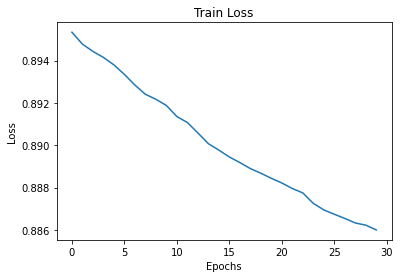

In [27]:
#visualize the loss during training
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_mnist_loss.png')

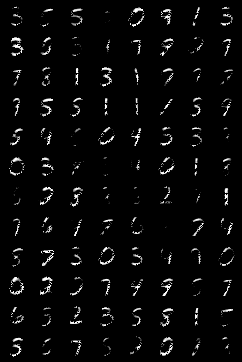

In [28]:
#visualize few images that are saved during training
Image.open('MNIST_Out_Images/Autoencoder_image0.png')

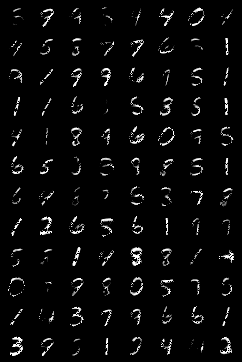

In [29]:
Image.open('MNIST_Out_Images/Autoencoder_image25.png')

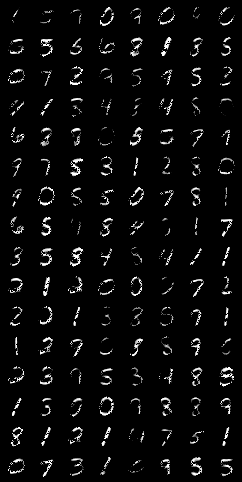

In [30]:
test_image_reconstruct(model, test_loader)

Image.open('MNIST_reconstructed_img.png')